In [1]:
from cgr.filepaths import filepaths
from cgr.draw import draw_molecule, draw_reaction
from cgr.cheminfo import MorganFingerprinter, extract_subgraph
import json
from IPython.display import SVG
from rdkit import Chem
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
from scipy.stats import entropy
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from itertools import chain

In [2]:
def pick_leaves(embeds, leaf, translator=None):
    asked, answered = zip(*[elt for elt in chain(*leaf)])

    if translator:
        asked = translator[asked]

    reaction_mask = []
    for q, a in zip(asked, answered):
        reaction_mask.append(embeds[:, q] == a)
    
    reaction_idxs = np.argwhere(np.prod(np.vstack(reaction_mask), axis=0).astype(int))

    return reaction_idxs.ravel()

In [3]:
krs = filepaths.data / "raw" / "sprhea_240310_v3_mapped_no_subunits.json"
with open(krs, 'r') as f:
    krs = json.load(f)

decarb = {k: v for k,v  in krs.items() if v['min_rule'] == 'rule0024'}
print(len(decarb))

86


In [4]:
max_hops = 3
vec_len = 2**12
mfper = MorganFingerprinter(radius=max_hops, length=vec_len, allocate_ao=True)
rc_dist_ub = None
n_samples = len(decarb)

full_embeds = []
subgraph_cts = defaultdict(lambda : defaultdict(int)) # {bit_idx: {(rid, central_aidx, radius): count}}
bit_examples = defaultdict(list) # {bit_idx: dict(mol, rid, central_aidx, radius)}
row2rid = list(decarb.keys())
for rid, rxn in decarb.items():
        rc = rxn['reaction_center'][0]
        smiles = rxn['smarts'].split('>>')[0]
        mol = Chem.MolFromSmiles(smiles)

        full_embeds.append(mfper.fingerprint(mol, reaction_center=rc, rc_dist_ub=rc_dist_ub))
        bim = mfper.bit_info_map


        for bit_idx, examples in bim.items():
            for (central_aidx, radius) in examples:
                bit_examples[bit_idx].append(
                    {
                        'mol': mol,
                        'rid': rid,
                        'central_aidx': central_aidx,
                        'radius': radius
                    }
                )

                sub_idxs, sub_mol, sub_smi = extract_subgraph(mol, central_aidx, radius)

                subgraph_cts[bit_idx][(sub_smi, radius)] += 1

full_embeds = np.vstack(full_embeds)

r2bits = defaultdict(list) # {radius: [bit idxs]}
for bit_idx, examples in subgraph_cts.items():
    r_max = sorted(examples.items(), key= lambda x : x[1], reverse=True)[0][0][1] # Sort by frequency over rxns
    r2bits[r_max].append(bit_idx)

# Add in only the most common. This is wrong?
embed_stack = np.zeros(shape=(n_samples, vec_len, max_hops + 1))
for r, bits in r2bits.items():
    embed_stack[:, bits, r] = full_embeds[:, bits]

p1 = embed_stack.sum(axis=0) / n_samples
p1 = p1[np.newaxis, :]
probas = np.vstack((p1, (1 - p1)))
H = entropy(pk=probas, axis=0, base=2)
p1 = p1.squeeze()

# Filter out non-majority examples
tmp = {}
for r, idxs in r2bits.items():
     for idx in idxs:
          tmp[idx] = [elt for elt in bit_examples[idx] if elt['radius'] == r]

bit_examples = tmp

resolved_embeds = embed_stack.sum(axis=-1)

Scale-separated loc ecfp embeddings

Bit idx: 3710
Entropy = 0.0 bits
Probability: 1.00


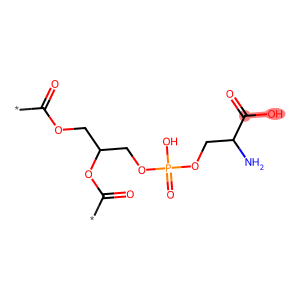

--------------------------------------------------
Bit idx: 795
Entropy = 0.0 bits
Probability: 1.00


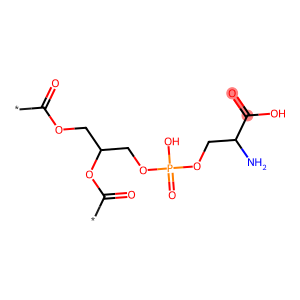

--------------------------------------------------
Bit idx: 1695
Entropy = 0.9902246902198684 bits
Probability: 0.44


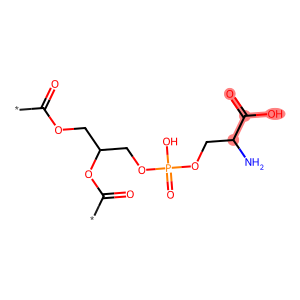

--------------------------------------------------
Bit idx: 3501
Entropy = 0.9221231306777972 bits
Probability: 0.34


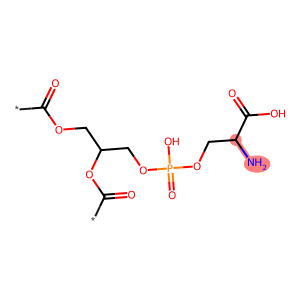

--------------------------------------------------
Bit idx: 269
Entropy = 0.9103480624345155 bits
Probability: 0.33


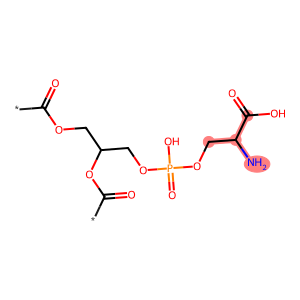

--------------------------------------------------
Bit idx: 3752
Entropy = 0.7618624463753669 bits
Probability: 0.22


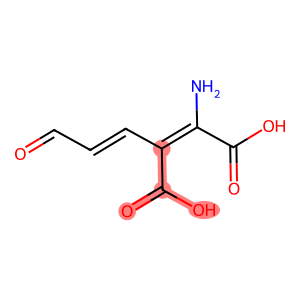

--------------------------------------------------
Bit idx: 3455
Entropy = 0.7401470427139037 bits
Probability: 0.21


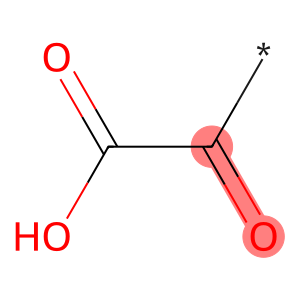

--------------------------------------------------
Bit idx: 1015
Entropy = 0.6409441847875289 bits
Probability: 0.16


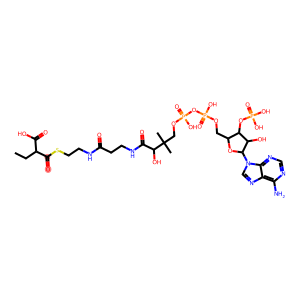

--------------------------------------------------
Bit idx: 3579
Entropy = 0.5830194167347008 bits
Probability: 0.14


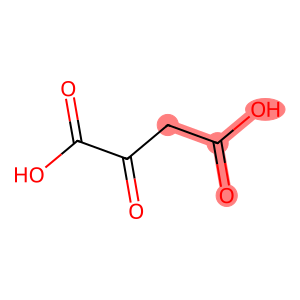

--------------------------------------------------
Bit idx: 1553
Entropy = 0.5516699920020824 bits
Probability: 0.13


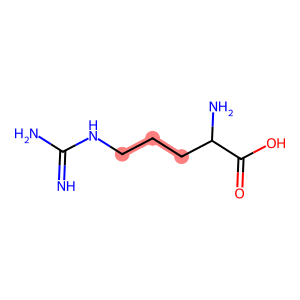

--------------------------------------------------
Bit idx: 2750
Entropy = 0.5516699920020824 bits
Probability: 0.13


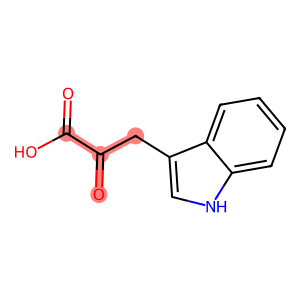

--------------------------------------------------
Bit idx: 3107
Entropy = 0.5516699920020824 bits
Probability: 0.13


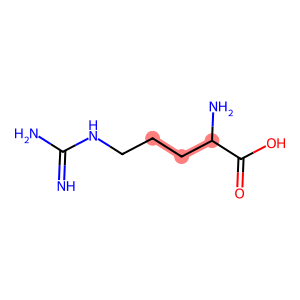

--------------------------------------------------
Bit idx: 3313
Entropy = 0.5185697317883058 bits
Probability: 0.12


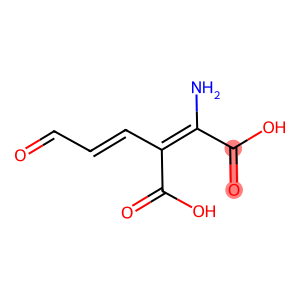

--------------------------------------------------
Bit idx: 3294
Entropy = 0.5185697317883058 bits
Probability: 0.12


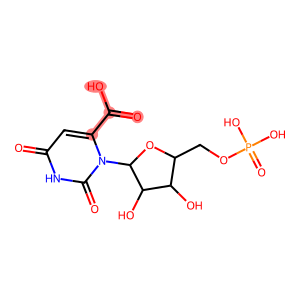

--------------------------------------------------
Bit idx: 1220
Entropy = 0.48356837509176975 bits
Probability: 0.10


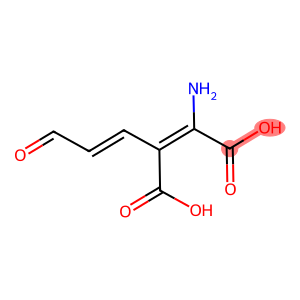

--------------------------------------------------
Bit idx: 3987
Entropy = 0.48356837509176975 bits
Probability: 0.10


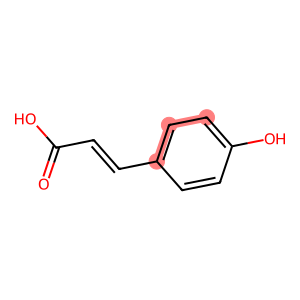

--------------------------------------------------
Bit idx: 14
Entropy = 0.48356837509176975 bits
Probability: 0.10


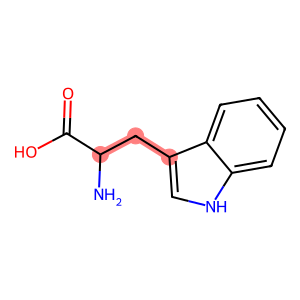

--------------------------------------------------
Bit idx: 3046
Entropy = 0.40707680632541937 bits
Probability: 0.08


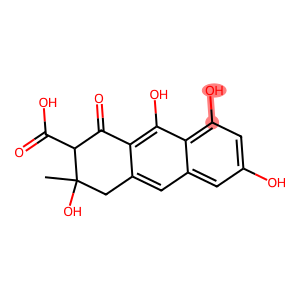

--------------------------------------------------
Bit idx: 3256
Entropy = 0.40707680632541937 bits
Probability: 0.08


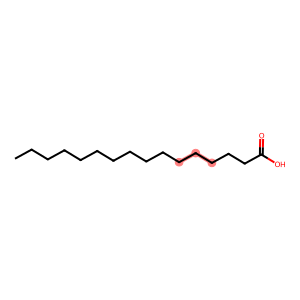

--------------------------------------------------
Bit idx: 1770
Entropy = 0.40707680632541937 bits
Probability: 0.08


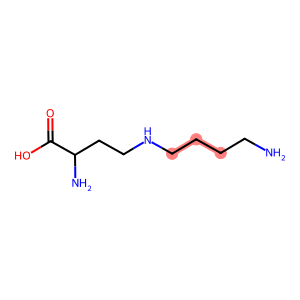

--------------------------------------------------
Bit idx: 3897
Entropy = 0.40707680632541937 bits
Probability: 0.08


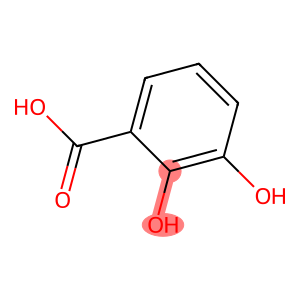

--------------------------------------------------
Bit idx: 1631
Entropy = 0.3650551896402849 bits
Probability: 0.07


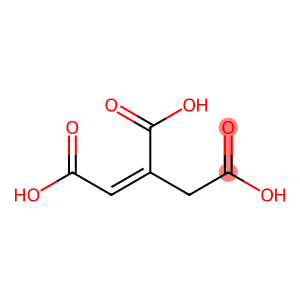

--------------------------------------------------
Bit idx: 1205
Entropy = 0.3650551896402849 bits
Probability: 0.07


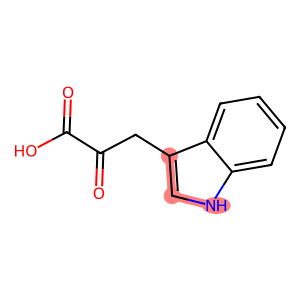

--------------------------------------------------
Bit idx: 1374
Entropy = 0.3650551896402849 bits
Probability: 0.07


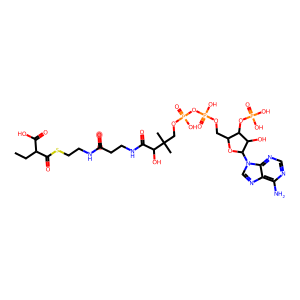

--------------------------------------------------
Bit idx: 1786
Entropy = 0.3650551896402849 bits
Probability: 0.07


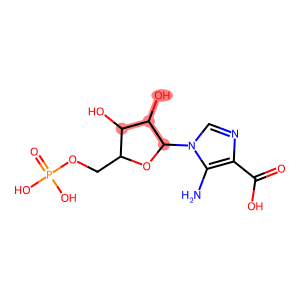

--------------------------------------------------
Bit idx: 1820
Entropy = 0.3650551896402849 bits
Probability: 0.07


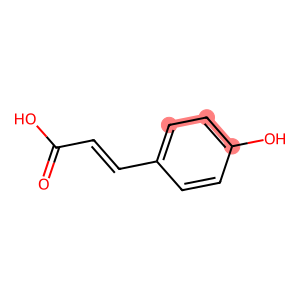

--------------------------------------------------
Bit idx: 3575
Entropy = 0.3200148627475466 bits
Probability: 0.06


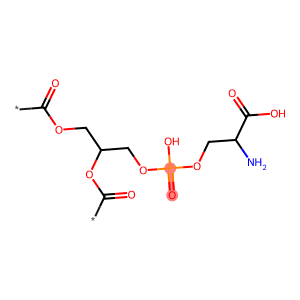

--------------------------------------------------
Bit idx: 1153
Entropy = 0.3200148627475466 bits
Probability: 0.06


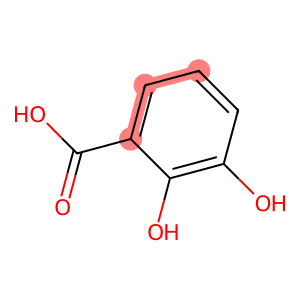

--------------------------------------------------
Bit idx: 942
Entropy = 0.3200148627475466 bits
Probability: 0.06


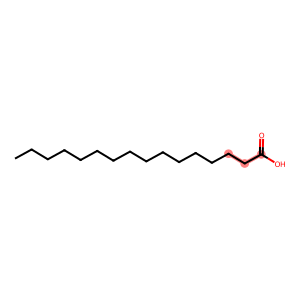

--------------------------------------------------
Bit idx: 2565
Entropy = 0.3200148627475466 bits
Probability: 0.06


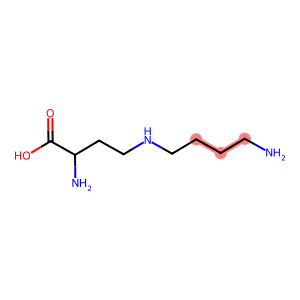

--------------------------------------------------
Bit idx: 2106
Entropy = 0.3200148627475466 bits
Probability: 0.06


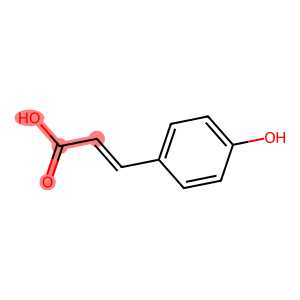

--------------------------------------------------
Bit idx: 972
Entropy = 0.3200148627475466 bits
Probability: 0.06


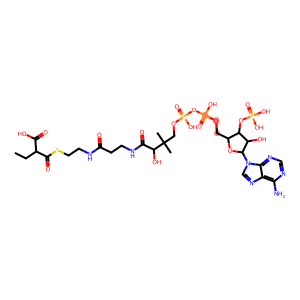

--------------------------------------------------
Bit idx: 2675
Entropy = 0.3200148627475466 bits
Probability: 0.06


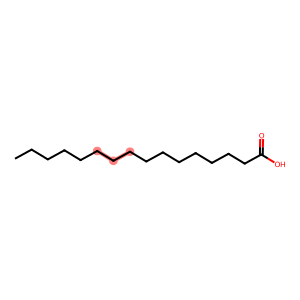

--------------------------------------------------
Bit idx: 2582
Entropy = 0.3200148627475466 bits
Probability: 0.06


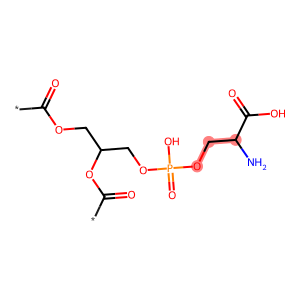

--------------------------------------------------
Bit idx: 72
Entropy = 0.3200148627475466 bits
Probability: 0.06


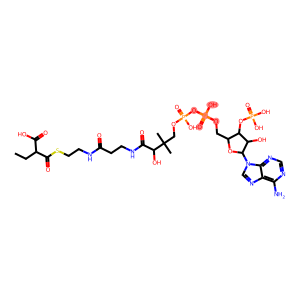

--------------------------------------------------
Bit idx: 3028
Entropy = 0.3200148627475466 bits
Probability: 0.06


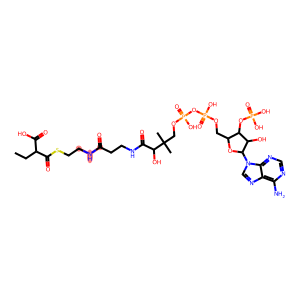

--------------------------------------------------
Bit idx: 761
Entropy = 0.3200148627475466 bits
Probability: 0.06


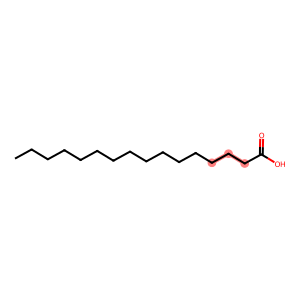

--------------------------------------------------
Bit idx: 26
Entropy = 0.3200148627475466 bits
Probability: 0.06


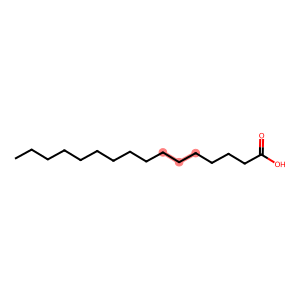

--------------------------------------------------
Bit idx: 1324
Entropy = 0.3200148627475466 bits
Probability: 0.06


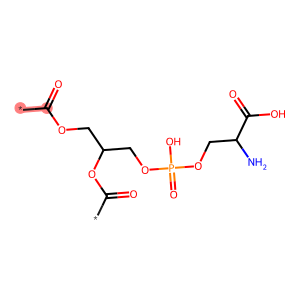

--------------------------------------------------
Bit idx: 979
Entropy = 0.3200148627475466 bits
Probability: 0.06


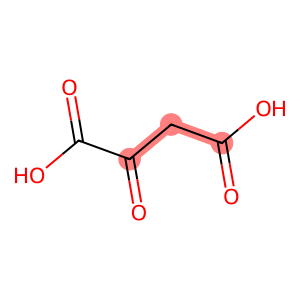

--------------------------------------------------
Bit idx: 639
Entropy = 0.3200148627475466 bits
Probability: 0.06


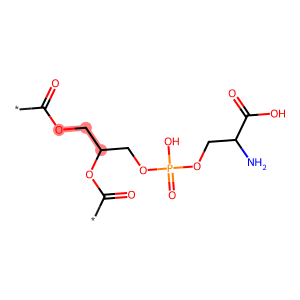

--------------------------------------------------
Bit idx: 679
Entropy = 0.3200148627475466 bits
Probability: 0.06


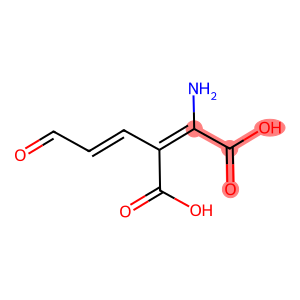

--------------------------------------------------
Bit idx: 597
Entropy = 0.3200148627475466 bits
Probability: 0.06


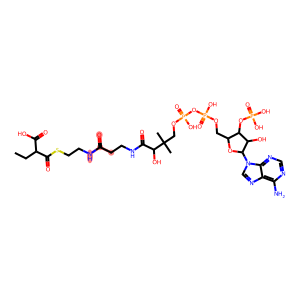

--------------------------------------------------
Bit idx: 1697
Entropy = 0.2713895875081111 bits
Probability: 0.05


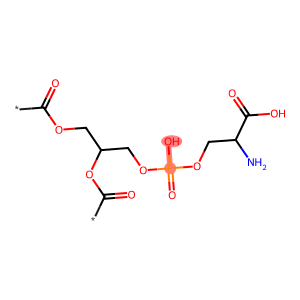

--------------------------------------------------
Bit idx: 2777
Entropy = 0.2713895875081111 bits
Probability: 0.05


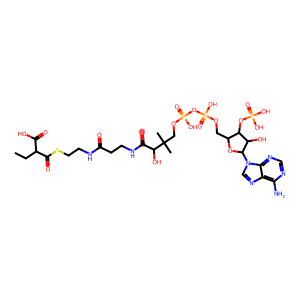

--------------------------------------------------
Bit idx: 835
Entropy = 0.2713895875081111 bits
Probability: 0.05


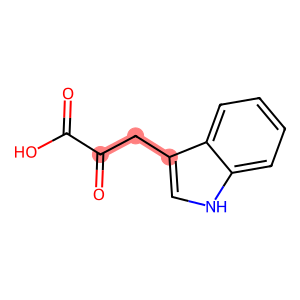

--------------------------------------------------
Bit idx: 2437
Entropy = 0.2713895875081111 bits
Probability: 0.05


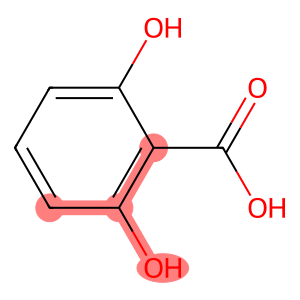

--------------------------------------------------
Bit idx: 246
Entropy = 0.2713895875081111 bits
Probability: 0.05


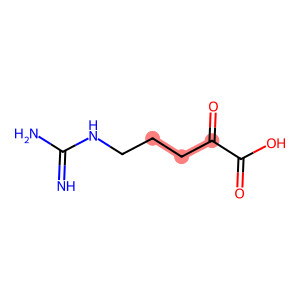

--------------------------------------------------
Bit idx: 2603
Entropy = 0.2713895875081111 bits
Probability: 0.05


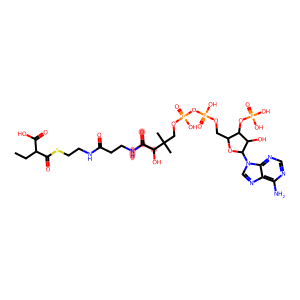

--------------------------------------------------
Bit idx: 3954
Entropy = 0.2713895875081111 bits
Probability: 0.05


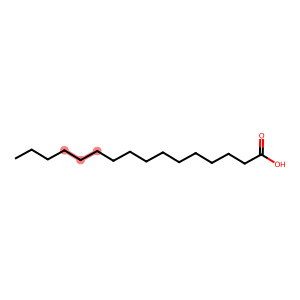

--------------------------------------------------
Bit idx: 557
Entropy = 0.2713895875081111 bits
Probability: 0.05


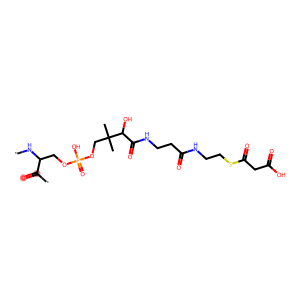

--------------------------------------------------
Bit idx: 2604
Entropy = 0.2713895875081111 bits
Probability: 0.05


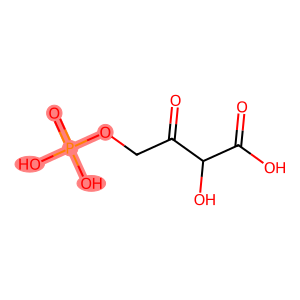

--------------------------------------------------
Bit idx: 578
Entropy = 0.2713895875081111 bits
Probability: 0.05


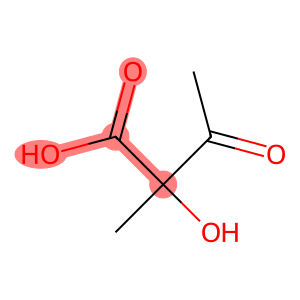

--------------------------------------------------
Bit idx: 260
Entropy = 0.2713895875081111 bits
Probability: 0.05


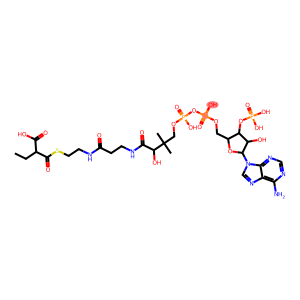

--------------------------------------------------
Bit idx: 384
Entropy = 0.2713895875081111 bits
Probability: 0.05


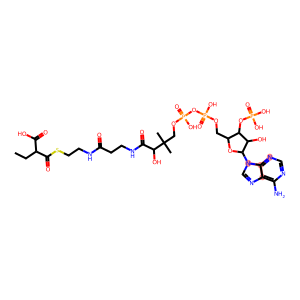

--------------------------------------------------
Bit idx: 3682
Entropy = 0.2713895875081111 bits
Probability: 0.05


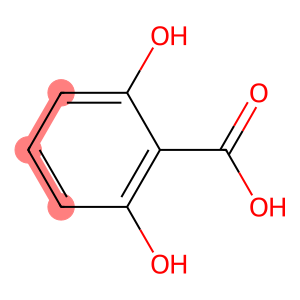

--------------------------------------------------
Bit idx: 1313
Entropy = 0.2713895875081111 bits
Probability: 0.05


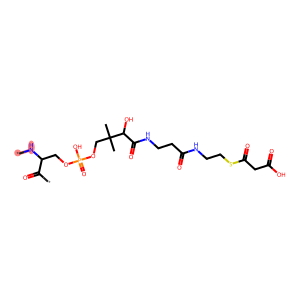

--------------------------------------------------
Bit idx: 3229
Entropy = 0.2713895875081111 bits
Probability: 0.05


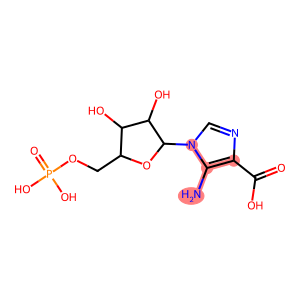

--------------------------------------------------
Bit idx: 3348
Entropy = 0.2713895875081111 bits
Probability: 0.05


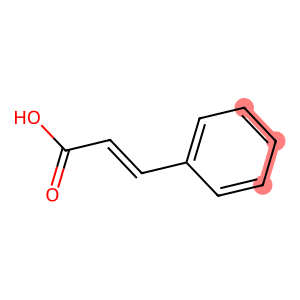

--------------------------------------------------
Bit idx: 232
Entropy = 0.2713895875081111 bits
Probability: 0.05


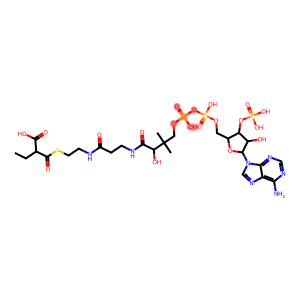

--------------------------------------------------
Bit idx: 358
Entropy = 0.2713895875081111 bits
Probability: 0.05


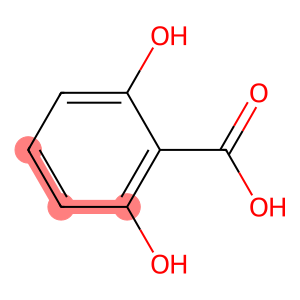

--------------------------------------------------
Bit idx: 2904
Entropy = 0.2713895875081111 bits
Probability: 0.05


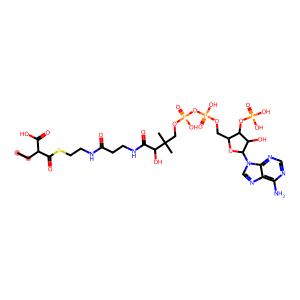

--------------------------------------------------
Bit idx: 2532
Entropy = 0.2713895875081111 bits
Probability: 0.05


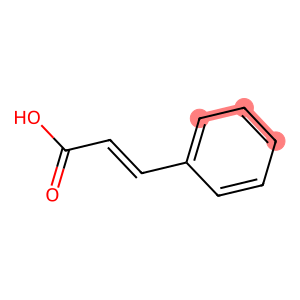

--------------------------------------------------
Bit idx: 1415
Entropy = 0.2713895875081111 bits
Probability: 0.05


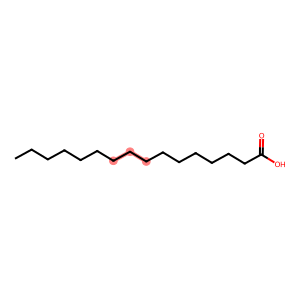

--------------------------------------------------
Bit idx: 2766
Entropy = 0.2713895875081111 bits
Probability: 0.05


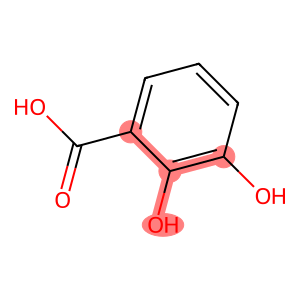

--------------------------------------------------
Bit idx: 1835
Entropy = 0.2713895875081111 bits
Probability: 0.05


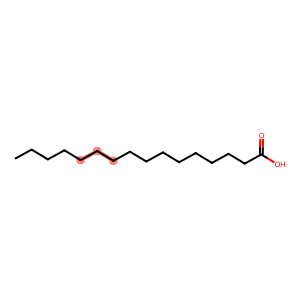

--------------------------------------------------
Bit idx: 3502
Entropy = 0.21832103023746738 bits
Probability: 0.03


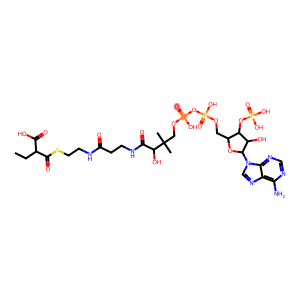

--------------------------------------------------
Bit idx: 651
Entropy = 0.21832103023746738 bits
Probability: 0.03


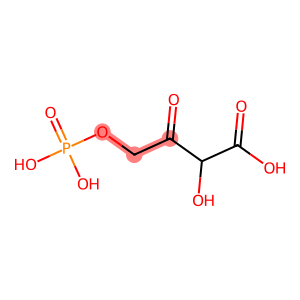

--------------------------------------------------
Bit idx: 1033
Entropy = 0.21832103023746738 bits
Probability: 0.03


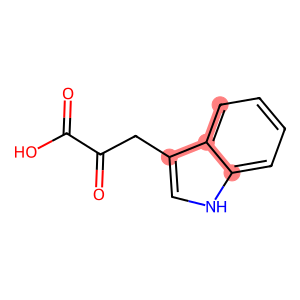

--------------------------------------------------
Bit idx: 2121
Entropy = 0.21832103023746738 bits
Probability: 0.03


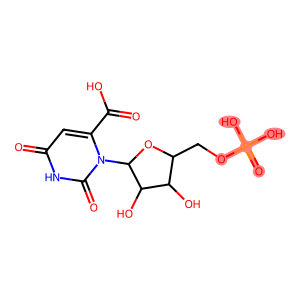

--------------------------------------------------
Bit idx: 776
Entropy = 0.21832103023746738 bits
Probability: 0.03


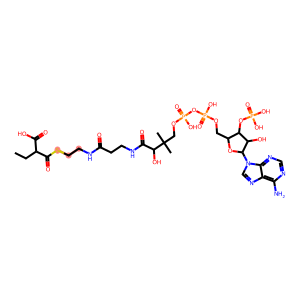

--------------------------------------------------
Bit idx: 3065
Entropy = 0.21832103023746738 bits
Probability: 0.03


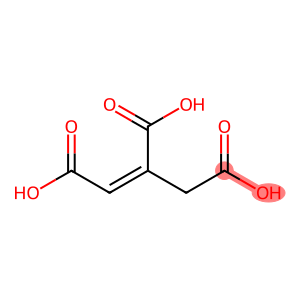

--------------------------------------------------
Bit idx: 2989
Entropy = 0.21832103023746738 bits
Probability: 0.03


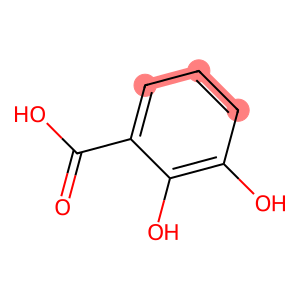

--------------------------------------------------
Bit idx: 1847
Entropy = 0.21832103023746738 bits
Probability: 0.03


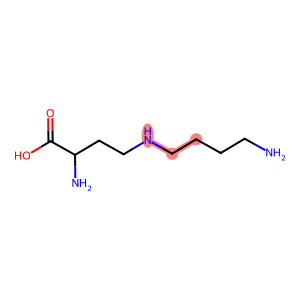

--------------------------------------------------
Bit idx: 3739
Entropy = 0.21832103023746738 bits
Probability: 0.03


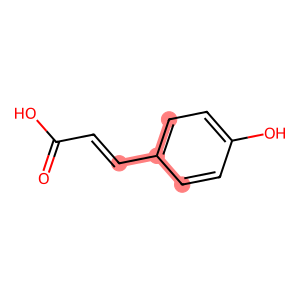

--------------------------------------------------
Bit idx: 2009
Entropy = 0.21832103023746738 bits
Probability: 0.03


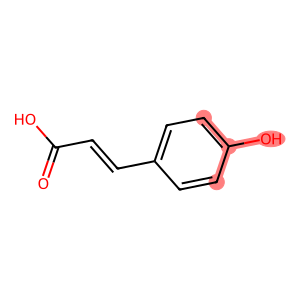

--------------------------------------------------
Bit idx: 1593
Entropy = 0.21832103023746738 bits
Probability: 0.03


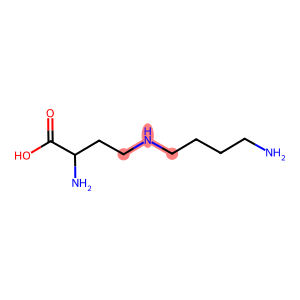

--------------------------------------------------
Bit idx: 2579
Entropy = 0.21832103023746738 bits
Probability: 0.03


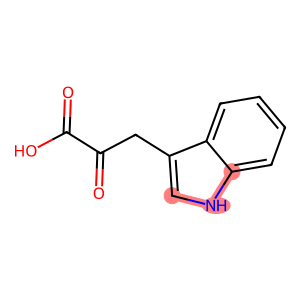

--------------------------------------------------
Bit idx: 1385
Entropy = 0.21832103023746738 bits
Probability: 0.03


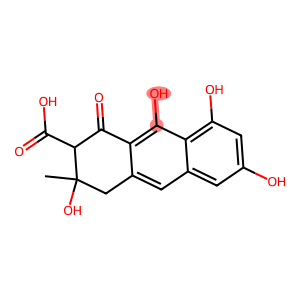

--------------------------------------------------
Bit idx: 455
Entropy = 0.21832103023746738 bits
Probability: 0.03


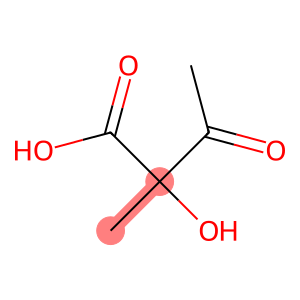

--------------------------------------------------
Bit idx: 143
Entropy = 0.21832103023746738 bits
Probability: 0.03


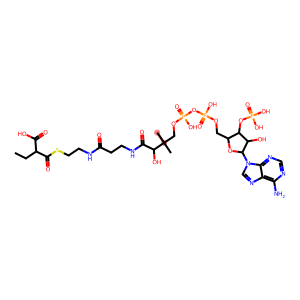

--------------------------------------------------
Bit idx: 3534
Entropy = 0.21832103023746738 bits
Probability: 0.03


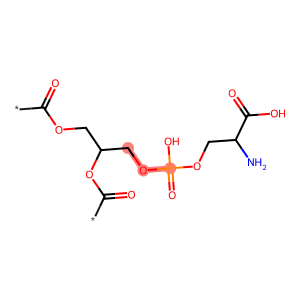

--------------------------------------------------
Bit idx: 3275
Entropy = 0.21832103023746738 bits
Probability: 0.03


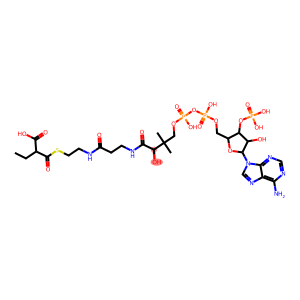

--------------------------------------------------
Bit idx: 3510
Entropy = 0.21832103023746738 bits
Probability: 0.03


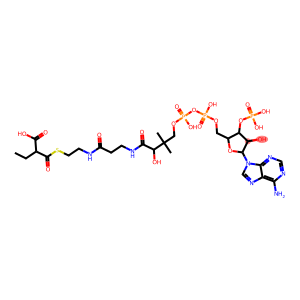

--------------------------------------------------
Bit idx: 1742
Entropy = 0.21832103023746738 bits
Probability: 0.03


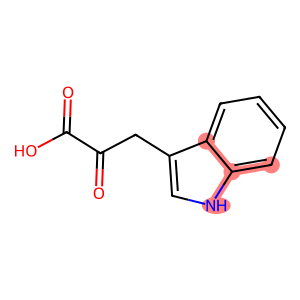

--------------------------------------------------
Bit idx: 415
Entropy = 0.21832103023746738 bits
Probability: 0.03


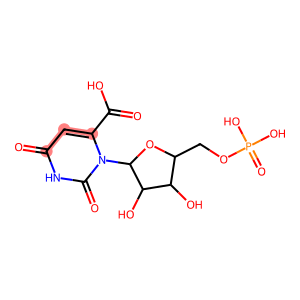

--------------------------------------------------
Bit idx: 3723
Entropy = 0.21832103023746738 bits
Probability: 0.03


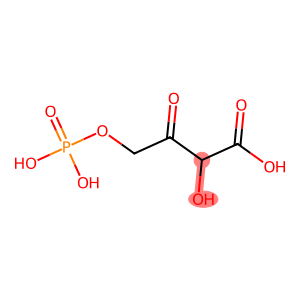

--------------------------------------------------
Bit idx: 3839
Entropy = 0.21832103023746738 bits
Probability: 0.03


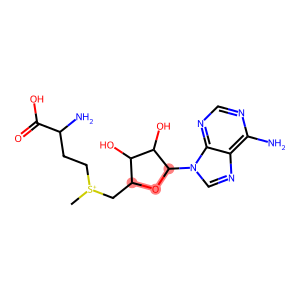

--------------------------------------------------
Bit idx: 671
Entropy = 0.21832103023746738 bits
Probability: 0.03


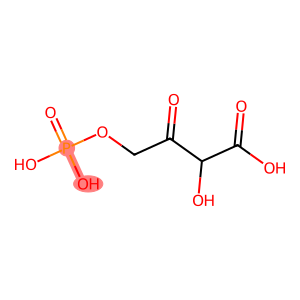

--------------------------------------------------
Bit idx: 439
Entropy = 0.21832103023746738 bits
Probability: 0.03


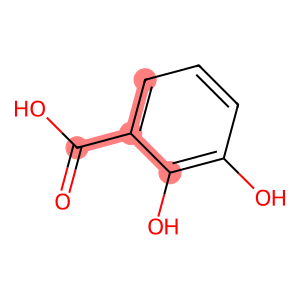

--------------------------------------------------
Bit idx: 2812
Entropy = 0.21832103023746738 bits
Probability: 0.03


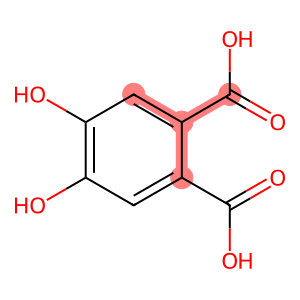

--------------------------------------------------
Bit idx: 1833
Entropy = 0.21832103023746738 bits
Probability: 0.03


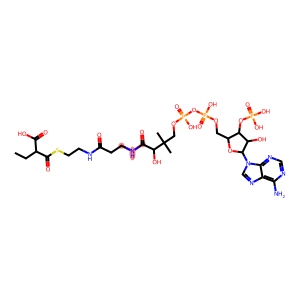

--------------------------------------------------
Bit idx: 2158
Entropy = 0.21832103023746738 bits
Probability: 0.03


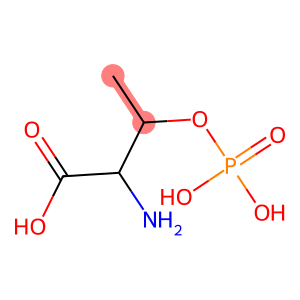

--------------------------------------------------
Bit idx: 3304
Entropy = 0.21832103023746738 bits
Probability: 0.03


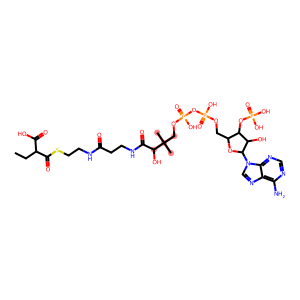

--------------------------------------------------
Bit idx: 1112
Entropy = 0.21832103023746738 bits
Probability: 0.03


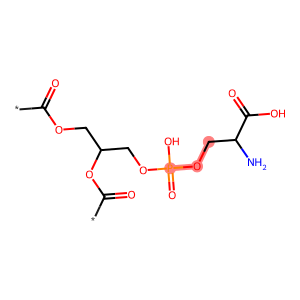

--------------------------------------------------
Bit idx: 2620
Entropy = 0.21832103023746738 bits
Probability: 0.03


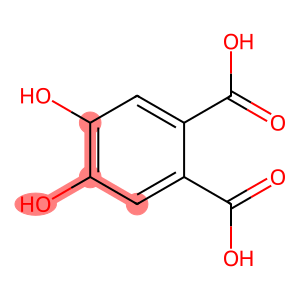

--------------------------------------------------
Bit idx: 3873
Entropy = 0.21832103023746738 bits
Probability: 0.03


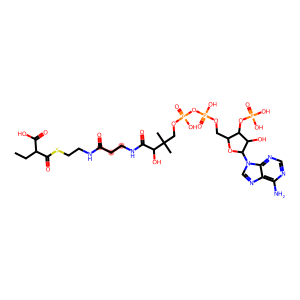

--------------------------------------------------
Bit idx: 1320
Entropy = 0.21832103023746738 bits
Probability: 0.03


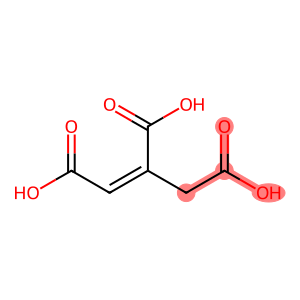

--------------------------------------------------
Bit idx: 703
Entropy = 0.21832103023746738 bits
Probability: 0.03


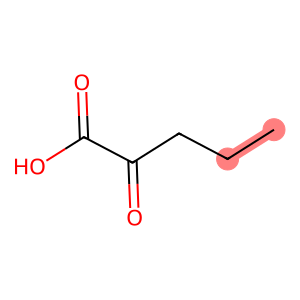

--------------------------------------------------
Bit idx: 2461
Entropy = 0.21832103023746738 bits
Probability: 0.03


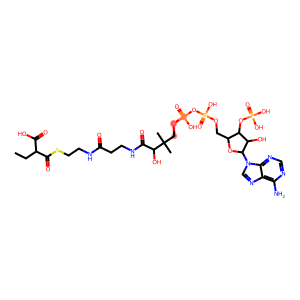

--------------------------------------------------


In [5]:
# rng = np.random.default_rng(seed=1234) # TODO seed=1234, resampling same integer for first hash / substruct
n_egs = 1
topk = 100
khop = 1 # Scale desired - how many hops from central atom
sort_by = p1

srt_idx = np.argsort(sort_by[:, khop])[::-1]

for idx in srt_idx[:topk]:
    egs = bit_examples[idx][:n_egs]
    print(f"Bit idx: {idx}")
    print(f"Entropy = {H[idx, khop]} bits")
    print(f"Probability: {p1[idx, khop]:.2f}")
    for eg in egs:
        mol = eg['mol']
        aidx = eg['central_aidx']
        r = eg['radius']

        sub_idxs, sub_mol, sub_smi = extract_subgraph(mol, aidx, r)

        display(SVG(draw_molecule(mol, size=(300, 300), hilite_atoms=tuple(sub_idxs))))
    
    print('-' * 50)
    

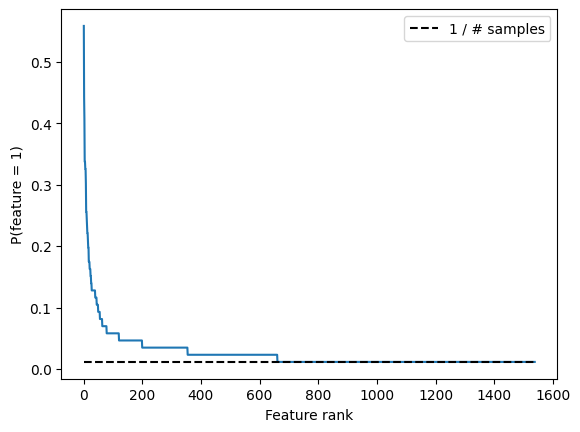

In [6]:
ft_proba_mass = resolved_embeds.sum(axis=0) / n_samples
nonzero_features = np.where((ft_proba_mass > 0) * (ft_proba_mass < 1))[0]
nonzero_embeds = resolved_embeds[:, nonzero_features]

resolved_p1 = nonzero_embeds.sum(axis=0) / n_samples
resolved_probas = np.vstack((resolved_p1, (1 - resolved_p1)))
resolved_H = entropy(pk=resolved_probas, axis=0, base=2)

fig, ax = plt.subplots()
ax.plot(np.arange(1, nonzero_embeds.shape[1] + 1), sorted(resolved_p1, reverse=True))
ax.set_ylabel("P(feature = 1)")
ax.set_xlabel("Feature rank")
ax.hlines(1 / n_samples, xmin=1, xmax=nonzero_embeds.shape[1], color='black', linestyles='--', label="1 / # samples")
ax.legend()
plt.show()

In [7]:
scl = 5
(resolved_p1 <= (scl / n_samples)).sum() / resolved_p1.shape

array([0.94928479])

Cluster structural features

In [8]:
def prune_embeds(embeds: np.ndarray, asked: list, not_asked: list, answered: list):
    reaction_mask = []
    for q, a in zip(asked, answered):
        reaction_mask.append(embeds[:, q] == a)
    
    if reaction_mask:
        reaction_mask = np.prod(np.vstack(reaction_mask), axis=0).astype(bool)
        remaining_embeds = embeds[reaction_mask, :][:, not_asked]
    else:
        remaining_embeds = embeds[:, not_asked]

    return remaining_embeds

def find_feature_clusters(embeds: np.ndarray, scl_lb:int = 1, leaves: list = []):
    def bts(qna: list[tuple[tuple]] = []):
        if qna:
            asked, answered = zip(*[elt for elt in chain(*qna)])
        else:
            asked, answered = [], []

        not_asked = np.array([i for i in range(embeds.shape[1]) if i not in asked]).astype(int)

        remaining_embeds = prune_embeds(embeds, asked, not_asked, answered)

        if remaining_embeds.shape[0] < 2:
            return qna

        n_remaining_rxns = remaining_embeds.shape[0]
        remaining_p1 = remaining_embeds.sum(axis=0) / n_remaining_rxns
        next_question = np.argmax(remaining_p1)

        if remaining_p1[next_question] <= (scl_lb / n_remaining_rxns):
            return qna

        next_distribution = remaining_embeds[:, next_question] # n_samples, 
        dots = remaining_embeds.T @ next_distribution.reshape(-1, 1) # n_remaingin_fts x 1
        jaccards = (dots / (next_distribution.sum() + remaining_embeds.T.sum(axis=1).reshape(-1, 1) - dots)).reshape(-1,)
        next_question = np.where(jaccards == 1)[0] # Get completely redundant features
        next_question = [int(elt) for elt in not_asked[next_question]] # Translate to indices of full feature space

        for ans in range(2):
            next_qna = tuple(zip(next_question, [ans for _ in range(len(next_question))]))
            leaves.append(
                bts(qna=qna + [next_qna])
            )
    
    bts()
    leaves = [l for l in leaves if l is not None]

    return leaves

In [9]:
test_embeds = np.array(
    [
        [1, 1, 1],
        [1, 0, 0],
        [0, 0, 0]
    ]
)

test_leaves = []
find_feature_clusters(test_embeds, leaves=test_leaves)

[[((0, 0),)], [((0, 1),)]]

In [10]:
nonzero_leaves = []
nonzero_leaves = find_feature_clusters(nonzero_embeds, scl_lb=5, leaves=nonzero_leaves)

In [11]:
len([l for l in nonzero_leaves if l is not None])

16

In [12]:
n_levels = []
n_rxns = []
for leaf in nonzero_leaves:
    n_levels.append(len(leaf))
    n_rxns.append(len(pick_leaves(nonzero_embeds, leaf)))

print(n_levels)
print(n_rxns)

[5, 5, 4, 3, 3, 4, 4, 3, 3, 3, 4, 6, 7, 8, 8, 5]
[3, 6, 7, 8, 5, 1, 8, 5, 11, 2, 2, 7, 3, 1, 6, 11]


[0, 1, 1, 0]
Bit idx: 1224. Present? 0
Entropy = 0.9902246902198684 bits
Probability: 0.56


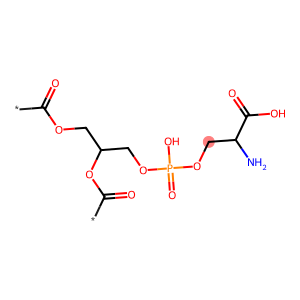

--------------------------------------------------
Bit idx: 3382. Present? 1
Entropy = 0.8019325020834525 bits
Probability: 0.24


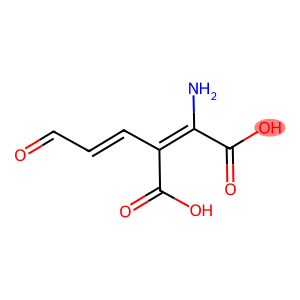

--------------------------------------------------
Bit idx: 1478. Present? 1
Entropy = 0.6677135405281421 bits
Probability: 0.17


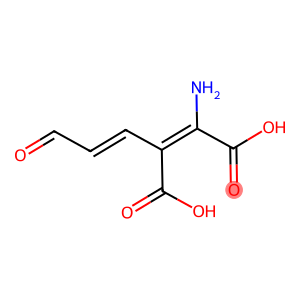

--------------------------------------------------
Bit idx: 166. Present? 0
Entropy = 0.5185697317883058 bits
Probability: 0.12


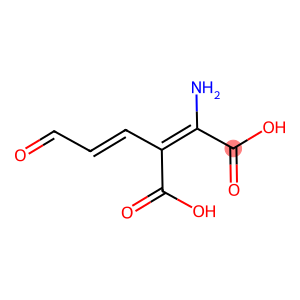

--------------------------------------------------
# cluster reactions: 1
['rule0024_06']
[11597]


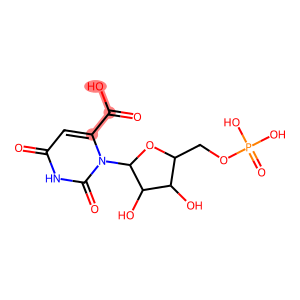

In [13]:
i = 5
n_egs = 1
leaves = nonzero_leaves

leaf = leaves[i]

print([elt[0][1] for elt in leaf])
for redundant_group in leaf:
    q, a = redundant_group[0]
    idx = nonzero_features[q] # Translate
    egs = bit_examples[idx][:n_egs]
    print(f"Bit idx: {idx}. Present? {a}")
    print(f"Entropy = {resolved_H[q]} bits")
    print(f"Probability: {resolved_p1[q]:.2f}")
    for eg in egs:
        mol = eg['mol']
        aidx = eg['central_aidx']
        r = eg['radius']

        sub_idxs, sub_mol, sub_smi = extract_subgraph(mol, aidx, r)

        display(SVG(draw_molecule(mol, size=(300, 300), hilite_atoms=tuple(sub_idxs))))
        
    print('-' * 50)

reaction_rows = pick_leaves(nonzero_embeds, leaf)
print(f"# cluster reactions: {len(reaction_rows)}")
for row in reaction_rows:
    rxn = decarb[row2rid[row]]
    print(rxn['imt_rules'])
    print(rxn['rhea_ids'])
    smiles = rxn['smarts'].split('>>')[0]
    rc = rxn['reaction_center'][0]
    display(SVG(draw_molecule(smiles, hilite_atoms=rc, size=(300, 300))))

# levels: 5
# cluster reactions: 3
['rule0024_52']
[10793]


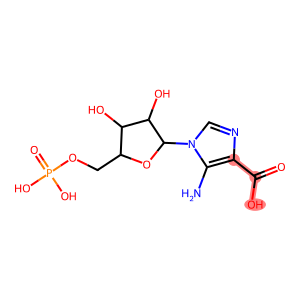

['rule0024_18']
[11493]


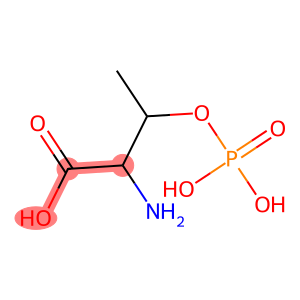

['rule0024_52']
[31376]


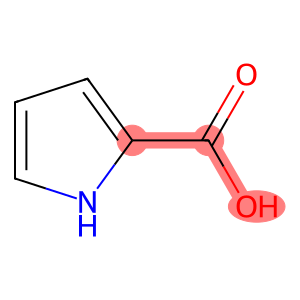

--------------------------------------------------
# levels: 5
# cluster reactions: 6
['rule0024_50']
[11629]


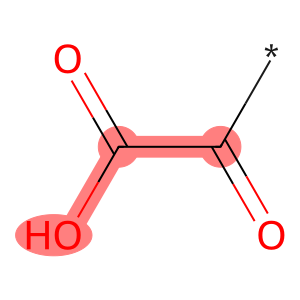

['rule0024_47']
[45485]


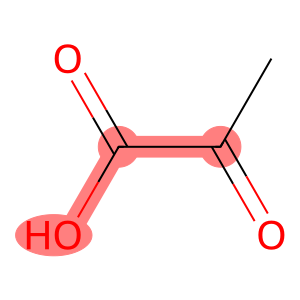

['rule0024_36']
[54357]


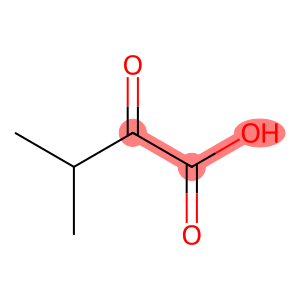

['rule0024_36']
[21109]


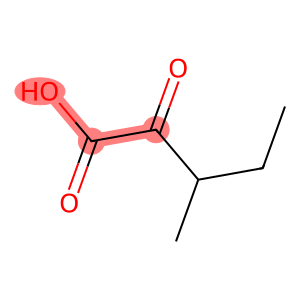

['rule0024_50']
[19334]


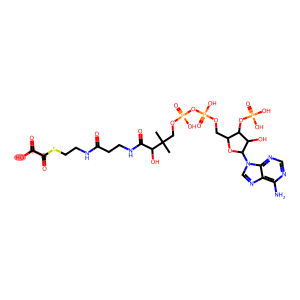

['rule0024_50']
[16510]


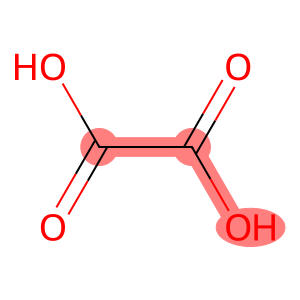

--------------------------------------------------
# levels: 4
# cluster reactions: 7
['rule0024_44']
[52405, 52417]


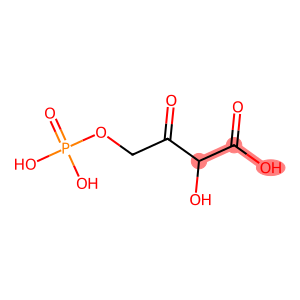

['rule0024_52']
[64265]


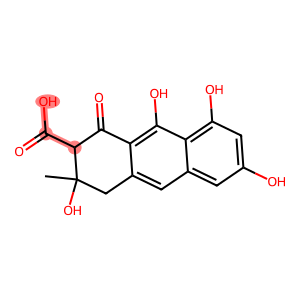

['rule0024_44']
[19730]


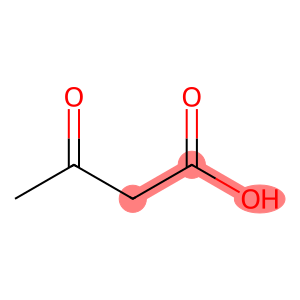

['rule0024_02']
[61341, 27667]


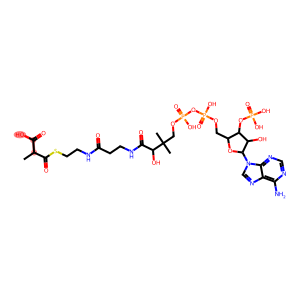

['rule0024_29']
[21581]


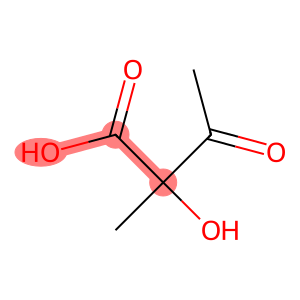

['rule0024_48']
[45161]


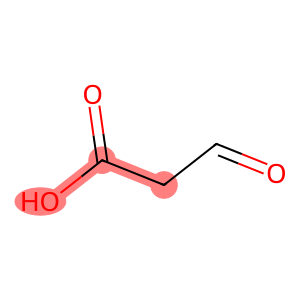

['rule0024_37']
[20514]


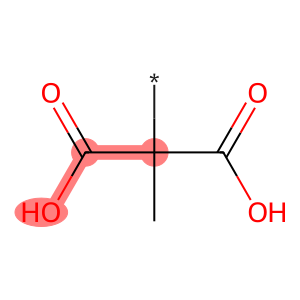

--------------------------------------------------
# levels: 3
# cluster reactions: 8
['rule0024_25']
[49465]


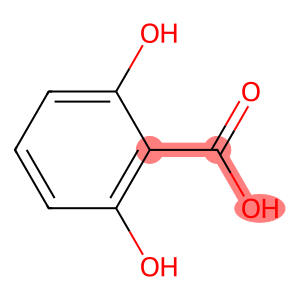

['rule0024_51']
[33228]


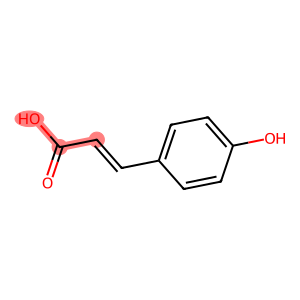

['rule0024_51']
[33808]


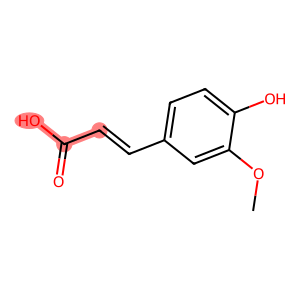

['rule0024_51']
[46921]


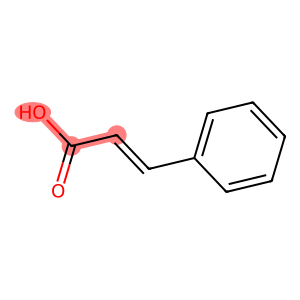

['rule0024_25']
[30704]


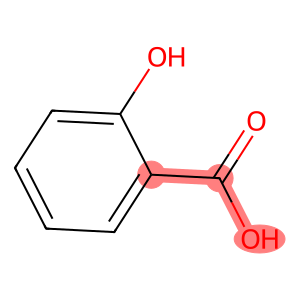

['rule0024_16']
[23369]


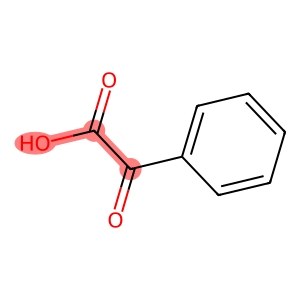

['rule0024_25']
[23113]


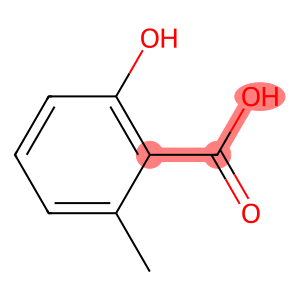

['rule0024_52']
[59217]


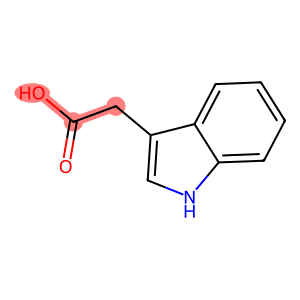

--------------------------------------------------
# levels: 3
# cluster reactions: 5
['rule0024_25']
[21493]


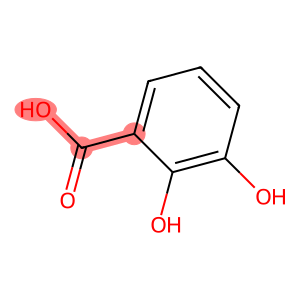

['rule0024_48']
[24461]


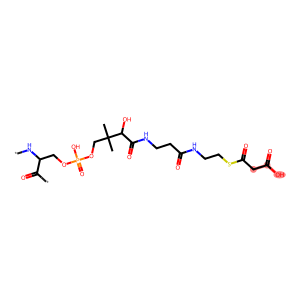

['rule0024_03']
[23917]


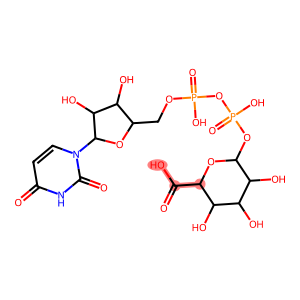

['rule0024_17']
[14354]


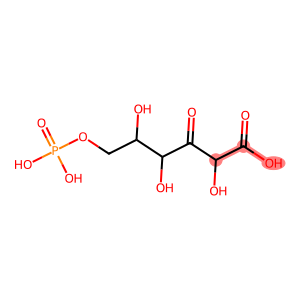

['rule0024_24']
[22417]


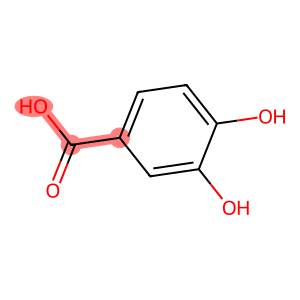

--------------------------------------------------
# levels: 4
# cluster reactions: 1
['rule0024_06']
[11597]


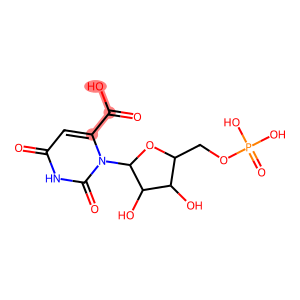

--------------------------------------------------
# levels: 4
# cluster reactions: 8
['rule0024_13']
[16558]


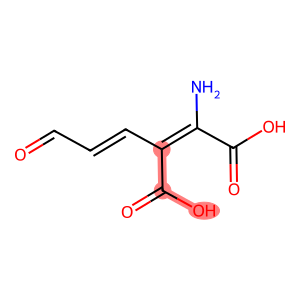

['rule0024_44']
[15642]


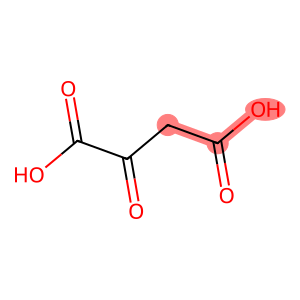

['rule0024_51']
[15254, 57729]


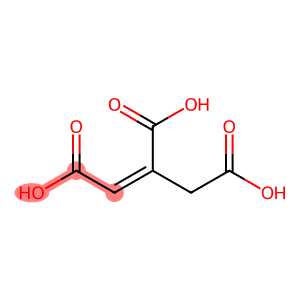

['rule0024_32']
[13318]


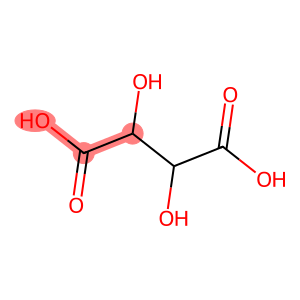

['rule0024_24']
[24185]


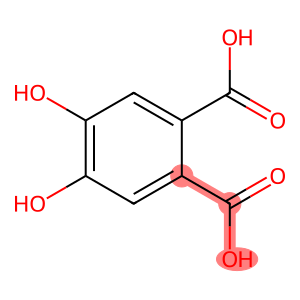

['rule0024_52']
[13670]


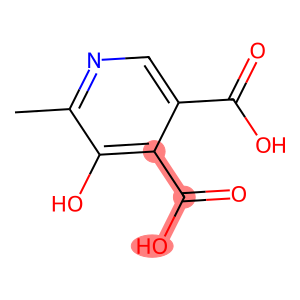

['rule0024_32']
[46277]


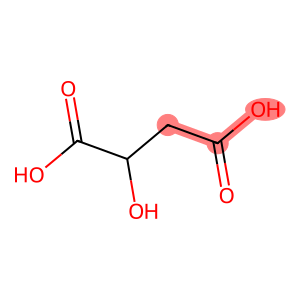

['rule0024_34']
[12622]


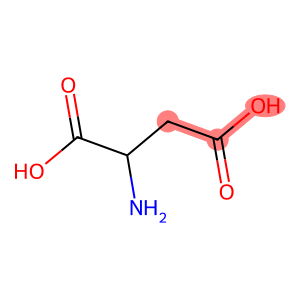

--------------------------------------------------
# levels: 3
# cluster reactions: 5
['rule0024_52']
[56061]


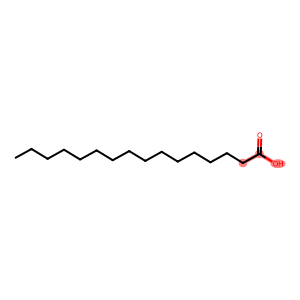

['rule0024_52']
[77376]


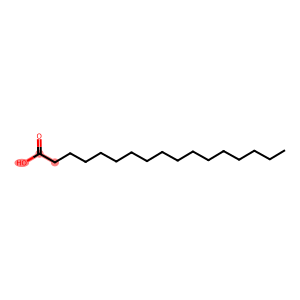

['rule0024_52']
[77244]


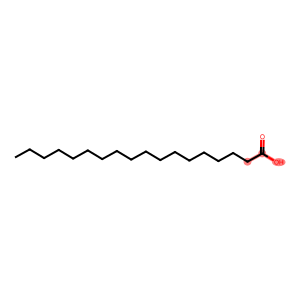

['rule0024_52']
[77384]


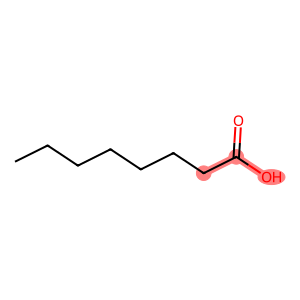

['rule0024_52']
[77380]


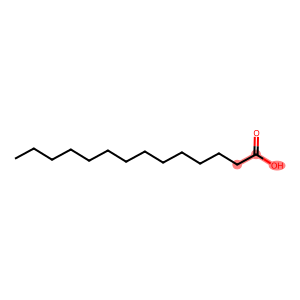

--------------------------------------------------
# levels: 3
# cluster reactions: 11
['rule0024_10']
[18018]


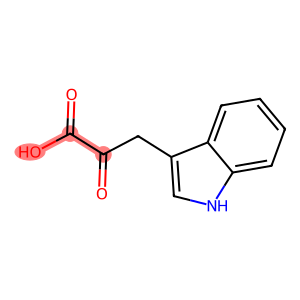

['rule0024_39']
[11341]


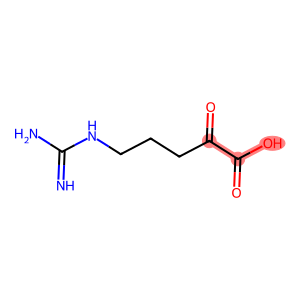

['rule0024_39']
[54361]


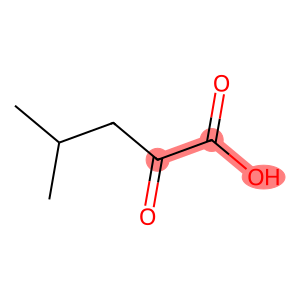

['rule0024_22']
[20949]


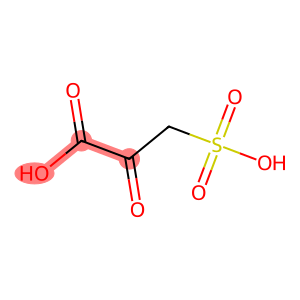

['rule0024_39']
[50313]


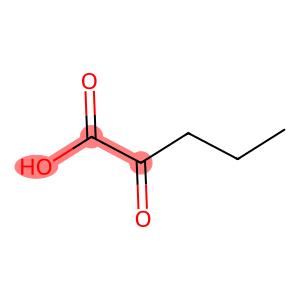

['rule0024_39']
[10525]


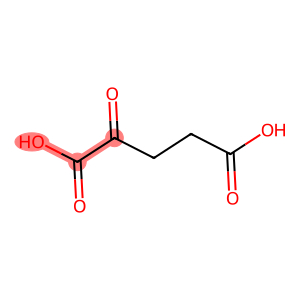

['rule0024_14']
[18698]


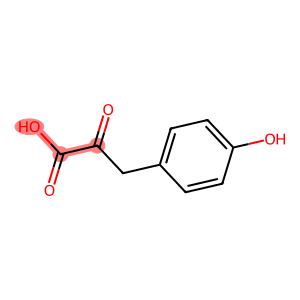

['rule0024_43']
[55073]


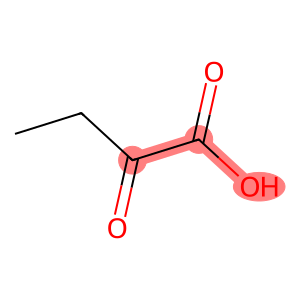

['rule0024_14']
[14186]


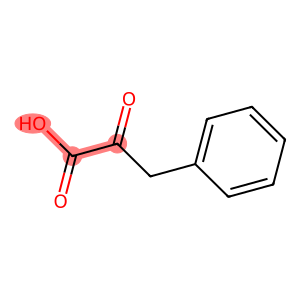

['rule0024_23']
[20769]


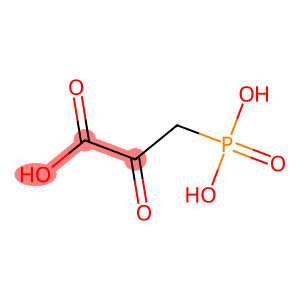

['rule0024_28']
[55077]


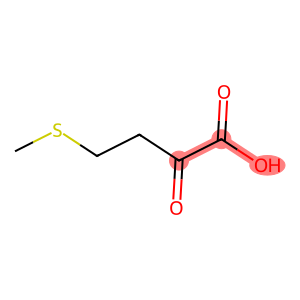

--------------------------------------------------
# levels: 3
# cluster reactions: 2
['rule0024_29']
[57073]


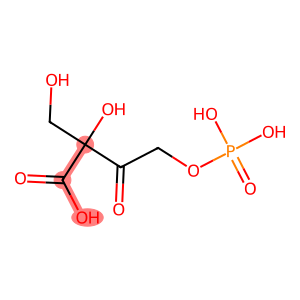

['rule0024_29']
[57053]


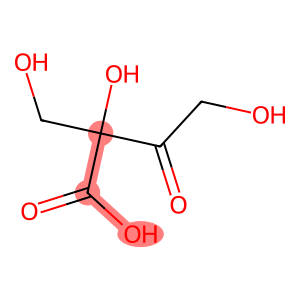

--------------------------------------------------
# levels: 4
# cluster reactions: 2
['rule0024_02']
[32132, 59541]


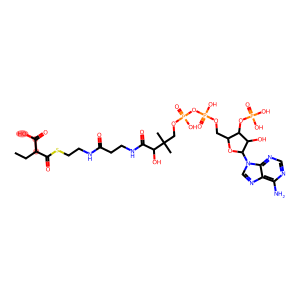

['rule0024_07']
[16794]


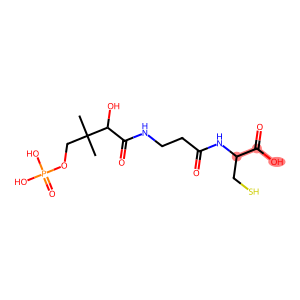

--------------------------------------------------
# levels: 6
# cluster reactions: 7
['rule0024_42']
[19498]


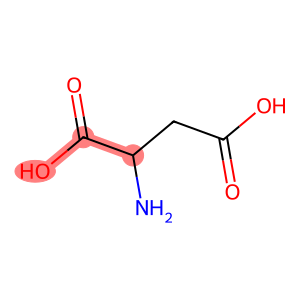

['rule0024_33']
[16878]


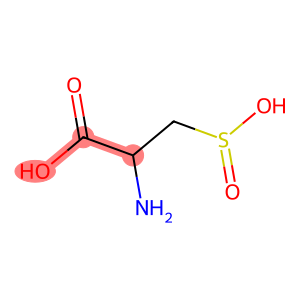

['rule0024_33']
[25222]


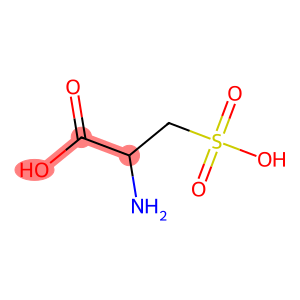

['rule0024_46']
[45825]


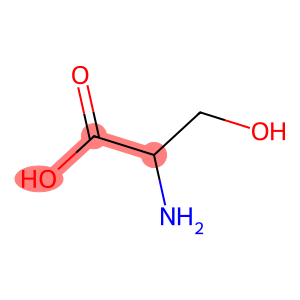

['rule0024_46']
[71572]


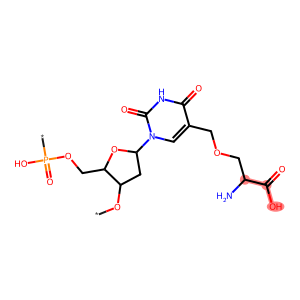

['rule0024_46']
[27747]


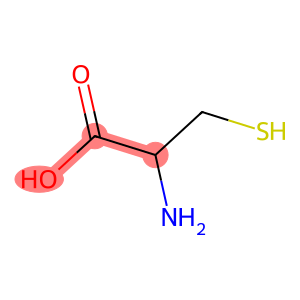

['rule0024_46']
[59121]


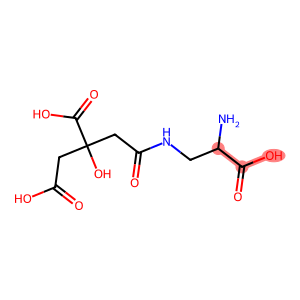

--------------------------------------------------
# levels: 7
# cluster reactions: 3
['rule0024_18']
[20829]


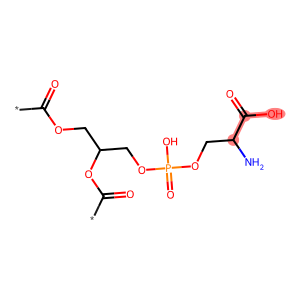

['rule0024_18']
[51489]


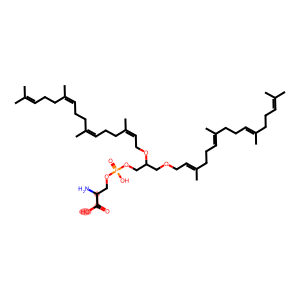

['rule0024_18']
[69549]


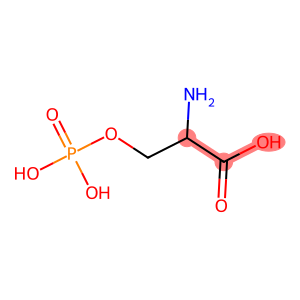

--------------------------------------------------
# levels: 8
# cluster reactions: 1
['rule0024_46']
[71556]


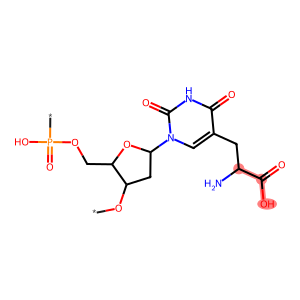

--------------------------------------------------
# levels: 8
# cluster reactions: 6
['rule0024_11']
[30340]


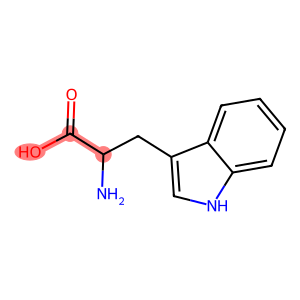

['rule0024_20']
[20841]


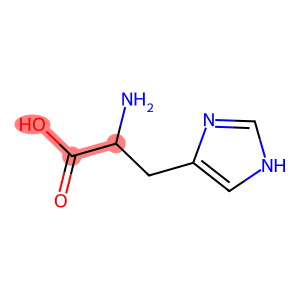

['rule0024_15']
[12273]


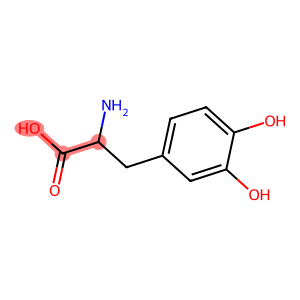

['rule0024_15']
[19718]


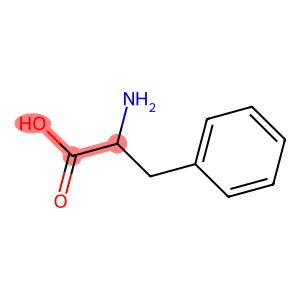

['rule0024_15']
[14346]


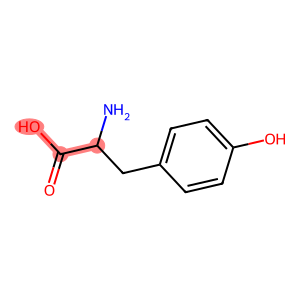

['rule0024_11']
[18534]


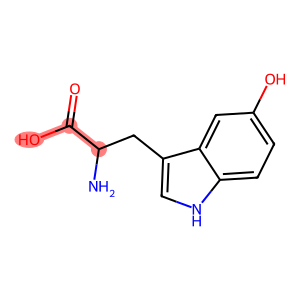

--------------------------------------------------
# levels: 5
# cluster reactions: 11
['rule0024_40']
[17642]


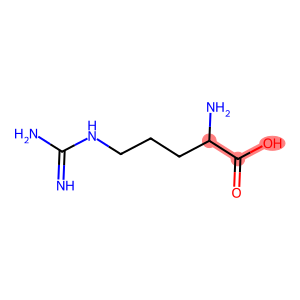

['rule0024_05']
[15982]


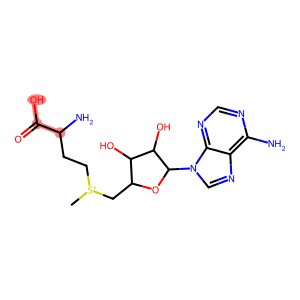

['rule0024_40']
[22965, 59049]


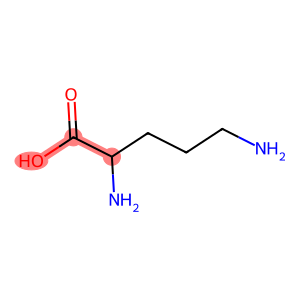

['rule0024_40']
[15102]


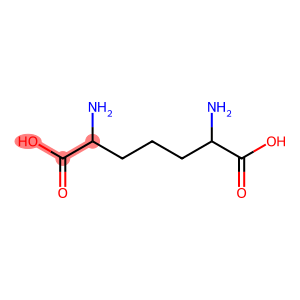

['rule0024_40']
[17786]


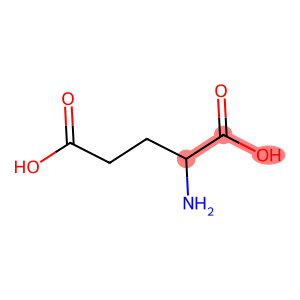

['rule0024_41']
[34096]


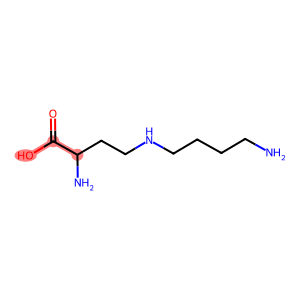

['rule0024_41']
[34100]


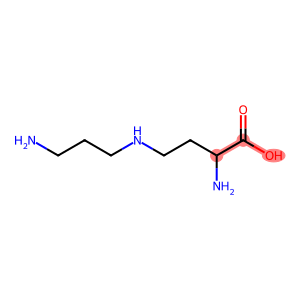

['rule0024_40']
[22353, 59053]


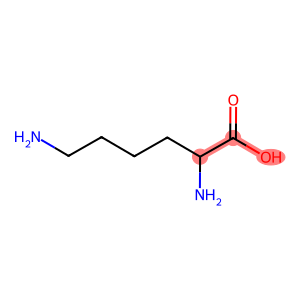

['rule0024_41']
[15690]


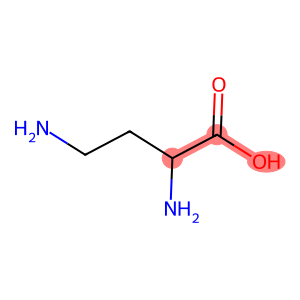

['rule0024_40']
[53957]


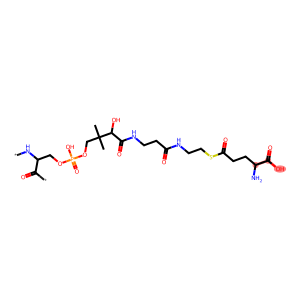

['rule0024_40']
[74528]


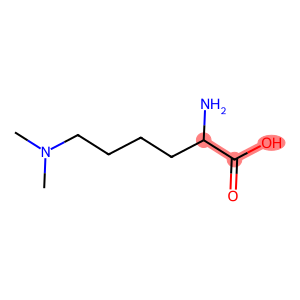

--------------------------------------------------


In [14]:
for leaf in nonzero_leaves:
    reaction_rows = pick_leaves(nonzero_embeds, leaf)
    print(f"# levels: {len(leaf)}")
    print(f"# cluster reactions: {len(reaction_rows)}")
    for row in reaction_rows:
        rxn = decarb[row2rid[row]]
        print(rxn['imt_rules'])
        print(rxn['rhea_ids'])
        smiles = rxn['smarts'].split('>>')[0]
        rc = rxn['reaction_center'][0]
        display(SVG(draw_molecule(smiles, hilite_atoms=rc, size=(300, 300))))
    print("-" * 50)


Correlation & anti-correlation

In [15]:
embeds = full_embeds # embed_stack[:, :, 0]

ft_proba_mass = embeds.sum(axis=0) / n_samples
nonzero_features = np.where((ft_proba_mass > 0) * (ft_proba_mass < 1))[0]
nonzero_embeds = embeds[:, nonzero_features]
directed_embeds = (nonzero_embeds - 0.5) * 2
hamming_corr = np.matmul(directed_embeds.T, directed_embeds) / directed_embeds.shape[0]
triu_idxs = np.triu_indices_from(hamming_corr, k=1)
hamming_corr_upper = hamming_corr[triu_idxs]
feature_pairs = list(zip(*triu_idxs))


In [16]:
interaction_triple = np.zeros(shape=(nonzero_embeds.shape[1], nonzero_embeds.shape[1], 3))
for i in range(nonzero_embeds.shape[1] - 1):
    for j in range(i + 1, nonzero_embeds.shape[1]):
        raw_weights = Counter(nonzero_embeds[:, (i, j)].sum(axis=1))
        idxs, counts = zip(*raw_weights.items())
        counts = [ct / n_samples for ct in counts]
        interaction_triple[i, j, idxs] = counts